#### Before you run the notebook, make sure the homework files provided are in the same directory.
```
150180705/  
│   hw2.ipynb  
│
└───images/  
       aydemirakbas.png
       cat.jpg
       cat_landmarks.npy
       deniro.jpg
       gorilla.jpg
       gorilla_landmarks.npy
       kimbodnia.png
       panda.jpg
       panda_landmarks.npy
```

## PART 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dlib
import moviepy.editor as mpy

import os
import copy
import cv2

In [2]:
class DownloadFailedError(Exception):    # Weird flex but ok!
    def __init__(self, message="curl failed to download the model. Please download manually!"):
        self.message = message
        super().__init__(self.message)

shape_predictor_model = "shape_predictor_68_face_landmarks.dat"
if not os.path.isfile(shape_predictor_model):
    try:
        !curl https://raw.githubusercontent.com/davisking/dlib-models/master/shape_predictor_68_face_landmarks.dat.bz2 --output "shape_predictor_68_face_landmarks.dat.bz2"
    except:
        raise DownloadFailedError
    !bzip2 -d "shape_predictor_68_face_landmarks.dat.bz2"
else:
    print("Model already exists. Skipping download.")

Model already exists. Skipping download.


In [3]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor_model)

In [4]:
def concat_images(images):
    assert len(images) == 6, "There must be six images in order to be displayed in a 2x3 matrix fashion"
    row1 = np.hstack((images[:3]))
    row2 = np.hstack((images[3:]))
    all_images = np.vstack((row1, row2))
    return all_images

In [5]:
images = {file.split(".")[0]:cv2.cvtColor(cv2.imread(os.path.join("images", file)), cv2.COLOR_BGR2RGB) for file in os.listdir("images") if file.endswith(".png") or file.endswith(".jpg")}
original_images = copy.deepcopy(images)
landmarks = {file.split("_")[0]:np.load(os.path.join("images", file)) for file in os.listdir("images") if file.endswith(".npy")}

In [6]:
def dlib_landmarks_to_numpy(points):
    points_np = np.asarray([[points.parts()[i].x, points.parts()[i].y] for i in range(68)])
    return points_np

In [7]:
# Add landmarks of famous people to the landmarks dict
for key in ("deniro", "aydemirakbas", "kimbodnia"):
    gray = cv2.cvtColor(images[key], cv2.COLOR_BGR2GRAY)
    rectangles = detector(gray)
    landmarks[key] = dlib_landmarks_to_numpy(predictor(gray, rectangles[0]))

In [8]:
for key in images:
    for x, y in landmarks[key]:
        cv2.circle(images[key], (x, y), 3, (0, 255, 0), -1)

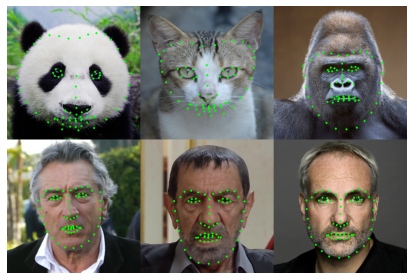

In [9]:
ordered_images = [images["panda"], images["cat"], images["gorilla"], images["deniro"], images["aydemirakbas"], images["kimbodnia"]]
all_images = concat_images(ordered_images)
plt.imshow(all_images)
plt.axis('off')
plt.tight_layout()

## PART 2

In [10]:
deniro_triangulation_image = original_images["deniro"].copy()
akbas_triangulation_image = original_images["aydemirakbas"].copy()
kim_triangulation_image = original_images["kimbodnia"].copy()

In [11]:
def get_subdiv(image, landmarks):
    subdiv = cv2.Subdiv2D((0, 0, image.shape[0], image.shape[1]))
    subdiv.insert(tuple(landmarks[i] for i in range(68)))
    # Corners
    subdiv.insert((0, 0))
    subdiv.insert((0, image.shape[1]-1))
    subdiv.insert((image.shape[0]-1, 0))
    subdiv.insert((image.shape[0]-1, image.shape[1]-1))
    # Centers of edges
    subdiv.insert((0, (image.shape[1]-1)//2))
    subdiv.insert(((image.shape[0]-1)//2, 0))
    subdiv.insert(((image.shape[0]-1)//2, image.shape[1]-1))
    subdiv.insert((image.shape[0]-1, (image.shape[1]-1)//2))
    return subdiv

In [12]:
# Doesn't function proparly due to problems with the cv2.getVertex() function
def create_triangles(subdiv_src, subdiv_trg):
    src_triangles = subdiv_src.getTriangleList().astype("uint32")
    trg_triangles = np.empty((len(src_triangles), 6)).astype("uint32")
    for idx in range(len(src_triangles)):
        p1 = subdiv_trg.getVertex(subdiv_src.findNearest(tuple(src_triangles[idx][0:2]))[0])[0]
        p2 = subdiv_trg.getVertex(subdiv_src.findNearest(tuple(src_triangles[idx][2:4]))[0])[0]
        p3 = subdiv_trg.getVertex(subdiv_src.findNearest(tuple(src_triangles[idx][4:6]))[0])[0]
        points = [p1[0], p1[1], p2[0], p2[1], p3[0], p3[1]]
        trg_triangles[idx:] = np.array(points)
    return trg_triangles

In [13]:
def create_triangles_using_landmarks(subdiv_src, landmarks_src, landmarks_trg):
    src_triangles = subdiv_src.getTriangleList().astype("uint32")
    trg_triangles = np.empty((len(src_triangles), 6)).astype("uint32")
    for idx in range(len(src_triangles)):
        p1_arr = np.where(np.all(src_triangles[idx][0:2] == landmarks_src, axis=1))
        if p1_arr[0].size == 0:
            p1 = src_triangles[idx][0:2]
        else:
            p1 = landmarks_trg[p1_arr[0][0]]
        p2_arr = np.where(np.all(src_triangles[idx][2:4] == landmarks_src, axis=1))
        if p2_arr[0].size == 0:
            p2 = src_triangles[idx][2:4]
        else:
            p2 = landmarks_trg[p2_arr[0][0]]
        p3_arr = np.where(np.all(src_triangles[idx][4:6] == landmarks_src, axis=1))
        if p3_arr[0].size == 0:
            p3 = src_triangles[idx][4:6]
        else:
            p3 = landmarks_trg[p3_arr[0][0]]
        points = [p1[0], p1[1], p2[0], p2[1], p3[0], p3[1]]
        trg_triangles[idx:] = np.array(points)
    return trg_triangles

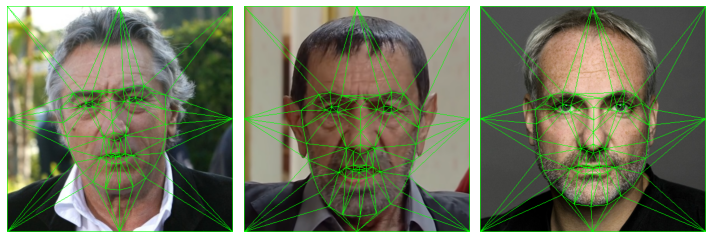

In [14]:
deniro_subdiv = get_subdiv(deniro_triangulation_image, landmarks["deniro"])
deniro_triangles = deniro_subdiv.getTriangleList().astype("uint32")
for triangle in deniro_triangles:
    t_points = [(triangle[0], triangle[1]), (triangle[2], triangle[3]), (triangle[4], triangle[5])]
    cv2.line(deniro_triangulation_image, t_points[0], t_points[1], (0, 255, 0), 1)
    cv2.line(deniro_triangulation_image, t_points[1], t_points[2], (0, 255, 0), 1)
    cv2.line(deniro_triangulation_image, t_points[0], t_points[2], (0, 255, 0), 1)
    
akbas_subdiv = get_subdiv(akbas_triangulation_image, landmarks["aydemirakbas"])
akbas_triangles = create_triangles(deniro_subdiv, akbas_subdiv)
for triangle in akbas_triangles:
    t_points = [(triangle[0], triangle[1]), (triangle[2], triangle[3]), (triangle[4], triangle[5])]
    cv2.line(akbas_triangulation_image, t_points[0], t_points[1], (0, 255, 0), 1)
    cv2.line(akbas_triangulation_image, t_points[1], t_points[2], (0, 255, 0), 1)
    cv2.line(akbas_triangulation_image, t_points[0], t_points[2], (0, 255, 0), 1)

kim_subdiv = get_subdiv(kim_triangulation_image, landmarks["kimbodnia"])
kim_triangles = create_triangles_using_landmarks(deniro_subdiv, landmarks["deniro"], landmarks["kimbodnia"])
for triangle in kim_triangles:
    t_points = [(triangle[0], triangle[1]), (triangle[2], triangle[3]), (triangle[4], triangle[5])]
    cv2.line(kim_triangulation_image, t_points[0], t_points[1], (0, 255, 0), 1)
    cv2.line(kim_triangulation_image, t_points[1], t_points[2], (0, 255, 0), 1)
    cv2.line(kim_triangulation_image, t_points[0], t_points[2], (0, 255, 0), 1)
    
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
axes[0].imshow(deniro_triangulation_image)
axes[1].imshow(akbas_triangulation_image)
axes[2].imshow(kim_triangulation_image)
for axis in axes:
    axis.set_axis_off()
fig.tight_layout()

## PART 3

In [15]:
def make_homogeneous(triangle):
    homogeneous = np.array([triangle[::2], triangle[1::2], [1, 1, 1]])    # (C)
    return homogeneous

def calc_transform(triangle1, triangle2):
    source = make_homogeneous(triangle1).T
    target = triangle2
    mtx = np.array([np.concatenate((source[0], np.zeros(3))),
                    np.concatenate((np.zeros(3), source[0])),
                    np.concatenate((source[1], np.zeros(3))),
                    np.concatenate((np.zeros(3), source[1])),
                    np.concatenate((source[2], np.zeros(3))),
                    np.concatenate((np.zeros(3), source[2]))])    # (D)
    coefs = np.matmul(np.linalg.pinv(mtx), target)    # (E)
    transform = np.array([coefs[:3], coefs[3:], [0, 0, 1]])    # (F)
    return transform

def vectorised_bilinear(coordinates, target_img, size):
    coordinates[0] = np.clip(coordinates[0], 0, size[0]-1)
    coordinates[1] = np.clip(coordinates[1], 0, size[1]-1)
    lower = np.floor(coordinates).astype(np.uint32)
    upper = np.ceil(coordinates).astype(np.uint32)
    
    error = coordinates - lower
    residual = 1 - error
    top_left = np.multiply(np.multiply(residual[0], residual[1]).reshape(coordinates.shape[1], 1), target_img[lower[0], lower[1], :])
    top_right = np.multiply(np.multiply(residual[0], error[1]).reshape(coordinates.shape[1], 1), target_img[lower[0], upper[1], :])
    bot_left = np.multiply(np.multiply(error[0], residual[1]).reshape(coordinates.shape[1], 1), target_img[upper[0], lower[1], :])
    bot_right = np.multiply(np.multiply(error[0], error[1]).reshape(coordinates.shape[1], 1), target_img[upper[0], upper[1], :])    # (G)
    return np.uint8(np.round(top_left + top_right + bot_left + bot_right))    # (H)

def image_morph(image1, image2, triangles1, triangles2, transforms, t):
    inter_image_1 = np.zeros(image1.shape).astype(np.uint8)
    inter_image_2 = np.zeros(image2.shape).astype(np.uint8)
    
    for i in range(len(transforms)):
        homo_inter_tri = (1 - t)*make_homogeneous(triangles1[i]) + t*make_homogeneous(triangles2[i])    # (I)
        
        polygon_mask = np.zeros(image1.shape[:2], dtype=np.uint8)
        cv2.fillPoly(polygon_mask, [np.int32(np.round(homo_inter_tri[1::-1, :].T))], color=255)    # (J)
        
        seg = np.where(polygon_mask == 255)    # (K)
        
        mask_points = np.vstack((seg[0], seg[1], np.ones(len(seg[0]))))    # (L)
        
        inter_tri = homo_inter_tri[:2].flatten(order="F")    # (M)
        
        inter_to_img1 = calc_transform(inter_tri, triangles1[i])
        inter_to_img2 = calc_transform(inter_tri, triangles2[i])
        
        mapped_to_img1 = np.matmul(inter_to_img1, mask_points)[:-1]    # (N)
        mapped_to_img2 = np.matmul(inter_to_img2, mask_points)[:-1]
        
        inter_image_1[seg[0], seg[1], :] = vectorised_bilinear(mapped_to_img1, image1, inter_image_1.shape)    # (O)
        inter_image_2[seg[0], seg[1], :] = vectorised_bilinear(mapped_to_img2, image2, inter_image_2.shape)

    result = (1 - t)*inter_image_1 + t*inter_image_2    # (P)
    return result.astype(np.uint8)        

In [16]:
def generate_frames(key1, key2):
    img1 = original_images[key1].copy()
    landmarks1 = landmarks[key1]
    img2 = original_images[key2].copy()
    landmarks2 = landmarks[key2]
    
    img1_subdiv = get_subdiv(img1, landmarks1)
    img1_triangles = img1_subdiv.getTriangleList().astype("uint32")
    
    img2_subdiv = get_subdiv(img2, landmarks2)
#     img2_triangles = create_triangles(img1_subdiv, img2_subdiv)
    img2_triangles = create_triangles_using_landmarks(img1_subdiv, landmarks1, landmarks2)
    
    img1_triangles = img1_triangles[:, [1,0,3,2,5,4]]
    img2_triangles = img2_triangles[:, [1,0,3,2,5,4]]
    
    transforms = np.zeros((len(img1_triangles), 3, 3))
    for i in range(len(img1_triangles)):
        source = img1_triangles[i]
        target = img2_triangles[i]
        transforms[i] = calc_transform(source, target)    # (A)
    
    morphs = []
    for t in np.arange(0, 1.00001, 0.02):    # (B)
        if t%0.1 == 0:
            print("Processing:\t{:05.2f}%".format(t*100))
        bgr_image = image_morph(img1, img2, img1_triangles, img2_triangles, transforms, t)[:, :, ::-1]
        rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
        morphs.append(rgb_image)
    return morphs

In [17]:
def render_morphing_video(source_image, destination_image):
    morphs = generate_frames(source_image, destination_image)
    clip = mpy.ImageSequenceClip(morphs, fps=24)
    clip.write_videofile("{}_to_{}.mp4".format(source_image, destination_image), codec="libx264")
    print("Finished Rendering!\n")

In [18]:
keys = {1:"panda", 2:"cat", 3:"gorilla", 4:"deniro", 5:"aydemirakbas", 6:"kimbodnia"}

source_image = keys[3]
destination_image = keys[5]
render_morphing_video(source_image, destination_image)
source_image = keys[1]
destination_image = keys[2]
render_morphing_video(source_image, destination_image)
source_image = keys[6]
destination_image = keys[4]
render_morphing_video(source_image, destination_image)

Processing:	00.00%
Processing:	10.00%
Processing:	20.00%
Processing:	40.00%
Processing:	80.00%


Moviepy - Building video gorilla_to_aydemirakbas.mp4.
Moviepy - Writing video gorilla_to_aydemirakbas.mp4

Moviepy - Done !


Moviepy - video ready gorilla_to_aydemirakbas.mp4
Finished Rendering!

Processing:	00.00%
Processing:	10.00%
Processing:	20.00%
Processing:	40.00%
Processing:	80.00%


Moviepy - Building video panda_to_cat.mp4.
Moviepy - Writing video panda_to_cat.mp4

Moviepy - Done !
Moviepy - video ready panda_to_cat.mp4
Finished Rendering!



Processing:	00.00%
Processing:	10.00%
Processing:	20.00%
Processing:	40.00%
Processing:	80.00%


Moviepy - Building video kimbodnia_to_deniro.mp4.
Moviepy - Writing video kimbodnia_to_deniro.mp4

Moviepy - Done !
Moviepy - video ready kimbodnia_to_deniro.mp4
Finished Rendering!

